# Lesson 2 - Batching

# Reuse KV-cache text generation function from Lesson 1
- Use the same prompt as the previous lesson to verify everything is working as expected

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

prompt = "The quick brown fox jumped over the"
inputs = tokenizer(prompt, return_tensors="pt")


def generate_token_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id, outputs.past_key_values


def generate(inputs, max_tokens):
    generated_tokens = []
    next_inputs = inputs
    for _ in range(max_tokens):
        next_token_id, past_key_values = \
        generate_token_with_past(next_inputs)
        next_inputs = {
            "input_ids": next_token_id.reshape((1, 1)),
            "attention_mask": torch.cat(
                [next_inputs["attention_mask"], torch.tensor([[1]])],
                dim=1
            ),
            "past_key_values": past_key_values,
        }
        next_token = tokenizer.decode(next_token_id)
        generated_tokens.append(next_token)
    return "".join(generated_tokens)


tokens = generate(inputs, max_tokens=10)
print(tokens)

/home/charles/miniconda3/envs/chatglm3-demo/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


 fence and ran to the other side of the fence


# Add padding tokens to the model to prepare batches of prompts

In [62]:
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

In [63]:
# pad on the left so we can append new tokens on the right
tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"

- Tokenize list of prompts
- Add padding so that all prompts have the same number of tokens as the longest prompt

In [64]:
# multiple prompts of varying lengths to send
# to the model at once
prompts = [
    "The quick brown fox jumped over the",
    "The rain in Spain falls",
    "What comes up must",
]

# note: padding=True ensures the padding token
# will be inserted into the tokenized tensors
inputs = tokenizer(prompts, padding=True, return_tensors="pt")

In [65]:
print("input_ids:", inputs["input_ids"])
print("shape:", inputs["input_ids"].shape)

input_ids: tensor([[  464,  2068,  7586, 21831, 11687,   625,   262],
        [50256, 50256,   464,  6290,   287,  8602,  8953],
        [50256, 50256, 50256,  2061,  2058,   510,  1276]])
shape: torch.Size([3, 7])


In [66]:
print("attention_mask:", inputs["attention_mask"])
print("shape:", inputs["attention_mask"].shape)

attention_mask: tensor([[1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1]])
shape: torch.Size([3, 7])


- Add position ids to track original order of tokens in each prompt
- Padding tokens are set to `1` and then first real token starts with position `0`

In [67]:
# position_ids tell the transformer the ordinal position
# of each token in the input sequence
# for single input inference, this is just [0 .. n]
# for n tokens, but for batch inference,
# we need to 0 out the padding tokens at the start of the sequence
attention_mask = inputs["attention_mask"]
position_ids = attention_mask.long().cumsum(-1) - 1
position_ids.masked_fill_(attention_mask == 0, 1)

tensor([[0, 1, 2, 3, 4, 5, 6],
        [1, 1, 0, 1, 2, 3, 4],
        [1, 1, 1, 0, 1, 2, 3]])

- Pass tokens to model to calculate logits

In [68]:
# same as before, but include the position_ids
with torch.no_grad():
    outputs = model(position_ids=position_ids, **inputs)
logits = outputs.logits

- Retrieve most likely token for each prompt

In [69]:
last_logits = logits[:, -1, :] 
next_token_ids = last_logits.argmax(dim=1) 

- Print the next token ids

In [70]:
print(next_token_ids)

tensor([13990,   319,   307])


- Convert the token ids into strings

In [71]:
next_tokens = tokenizer.batch_decode(next_token_ids)
next_tokens

[' fence', ' on', ' be']

# Let's put it all together!

- Generate tokens with past

In [72]:
def generate_batch_tokens_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)
    return next_token_ids, outputs.past_key_values

- Generate all tokens for some max tokens

In [73]:
def generate_batch(inputs, max_tokens):
    # create a list of tokens for every input in the batch
    generated_tokens = [[] for _ in range(inputs["input_ids"].shape[0])]

    attention_mask = inputs["attention_mask"]
    position_ids = attention_mask.long().cumsum(-1) - 1
    position_ids.masked_fill_(attention_mask == 0, 1)   

    next_inputs = {
        "position_ids": position_ids,
        **inputs,
    }

    for _ in range(max_tokens): 
        next_token_ids, past_key_values = \
            generate_batch_tokens_with_past(next_inputs)
        next_inputs = {
            "input_ids": next_token_ids.reshape((-1,1)),
            "position_ids": next_inputs["position_ids"][:,-1].unsqueeze(-1) + 1,
            "attention_mask": torch.cat(
                [next_inputs["attention_mask"], 
                torch.ones((next_token_ids.shape[0],1))],
                dim=1
            ),
            "past_key_values": past_key_values,
        }
        next_tokens = tokenizer.batch_decode(next_token_ids)
        for i , token in enumerate(next_tokens):
            generated_tokens[i].append(token)
    
    return ["".join(tokens) for tokens in generated_tokens]

- Call the generate_batch function and print out the generated tokens

In [74]:
generated_tokens = generate_batch(inputs, max_tokens=10)
for prompt, generated in zip(prompts, generated_tokens):
    print(prompt, f"\x1b[31m{generated}\x1b[0m\n")

The quick brown fox jumped over the  fence and ran to the other side of the fence

The rain in Spain falls  on the first day of the month, and the

What comes up must  be a good idea.

"I think



# Throughput vs Latency
- Explore the effect of batching on latency (how long it takes to generate each token)
- Observe the fundamental tradeoff that exists between throughout and latency.

**Note:** Your results might differ somewhat from those shown in the video, but they will still follow the same pattern as explained by the instructor.

In [78]:
# constants
max_tokens = 10

# observations
durations = []
throughputs = []
latencies = []

batch_sizes = [2**p for p in range(8)]
for batch_size in batch_sizes:
    print(f"bs= {batch_size}")

    # generate tokens for batch and record duration
    t0 = time.time()
    batch_prompts = [
        prompts[i % len(prompts)] for i in range(batch_size)
    ]
    inputs = tokenizer(
        batch_prompts, padding=True, return_tensors="pt"
    )
    generated_tokens = generate_batch(inputs, max_tokens=max_tokens)
    duration_s = time.time() - t0

    ntokens = batch_size * max_tokens
    throughput = ntokens / duration_s
    avg_latency = duration_s / max_tokens
    print("duration", duration_s)
    print("throughput", throughput)
    print("avg latency", avg_latency)    
    print()

    durations.append(duration_s)
    throughputs.append(throughput)
    latencies.append(avg_latency)

bs= 1
duration 0.8946988582611084
throughput 11.176945077850547
avg latency 0.08946988582611085

bs= 2
duration 0.45828914642333984
throughput 43.640570927955615
avg latency 0.04582891464233398

bs= 4
duration 0.5719597339630127
throughput 69.93499301576132
avg latency 0.05719597339630127

bs= 8
duration 0.7471516132354736
throughput 107.0733149508533
avg latency 0.07471516132354736

bs= 16
duration 0.906329870223999
throughput 176.5361655359059
avg latency 0.0906329870223999

bs= 32
duration 1.0550613403320312
throughput 303.29990093210597
avg latency 0.10550613403320312

bs= 64
duration 1.509817123413086
throughput 423.89239734757996
avg latency 0.15098171234130858

bs= 128
duration 2.3869290351867676
throughput 536.2538982646566
avg latency 0.23869290351867675



# Let's plot the throughput and latency observations against the batch size

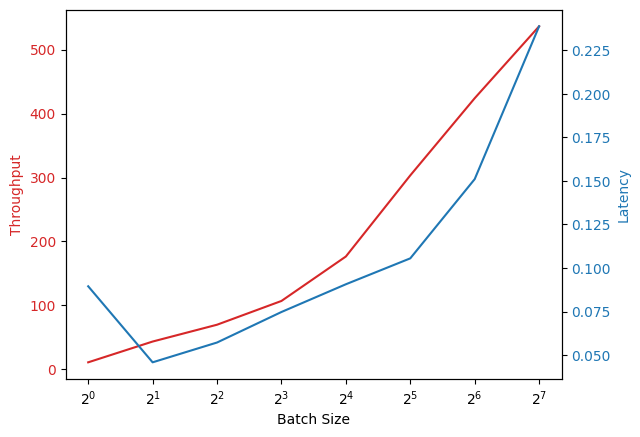

In [79]:
def render_plot(x, y1, y2, x_label, y1_label, y2_label):
    # Create a figure and a set of subplots
    fig, ax1 = plt.subplots()

    # Plot the first line (throughput)
    color = 'tab:red'
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y1_label, color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Set the x-axis to be log-scaled
    ax1.set_xscale('log', base=2)

    # Instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel(y2_label, color=color)  # we already handled the x-label with ax1
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()


render_plot(
    batch_sizes,
    throughputs,
    latencies,
    "Batch Size",
    "Throughput",
    "Latency"
)